# Play with NLP
*from https://scikit-learn.org/stable/auto_examples/classification/plot_digits_classification.html#sphx-glr-auto-examples-classification-plot-digits-classification-py*

In [7]:
from sklearn.datasets import fetch_openml
from sklearn import datasets, svm, metrics
from pandas import DataFrame
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stops = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/idvorkin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [64]:
# make the plot wider
height_in_inches=8
matplotlib.rc("figure", figsize=(2*height_in_inches,height_in_inches))

In [75]:
import glob
import os 
from nltk.tokenize import word_tokenize 

# Load corpus of my daily ramblings
mypath = os.path.expanduser("~/gits/igor2/750words/*md")
files = glob.glob(mypath)
data = ""
for file_name in files:
      with open (file_name) as myfile:
            data += str(myfile.read())
            
words = data.lower().split()

# clean up words that don't help analysis.
remove_words = set("Daily Know Affirmations Deliberate Essential get that's - ".lower().split(" "))
words = [word for word in words if not word in stops and not word in remove_words]


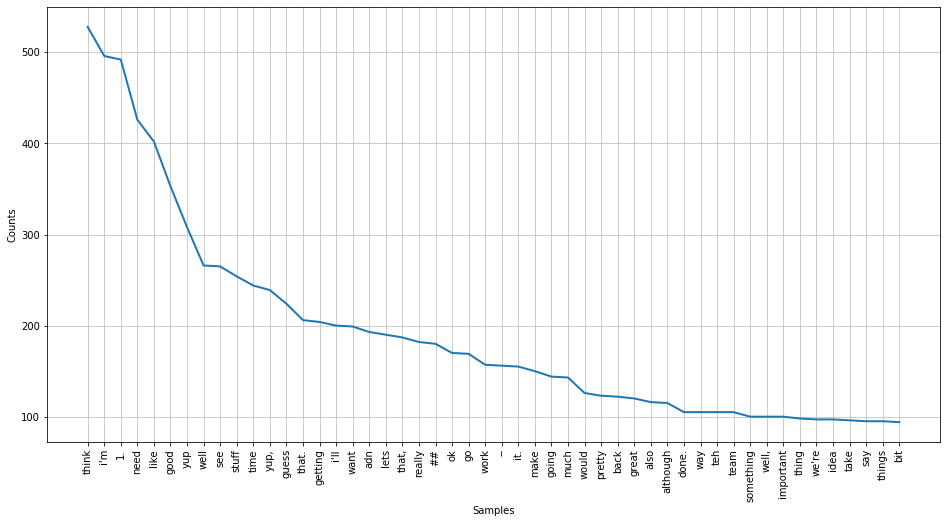

In [76]:
fd = nltk.FreqDist(words)
fd.plot(50, percents=True)

In [77]:
pd = DataFrame(words, columns=["word"])
pd.head()

,word
0,750
1,words
2,for:2018-08-18
3,testing
4,"so,"


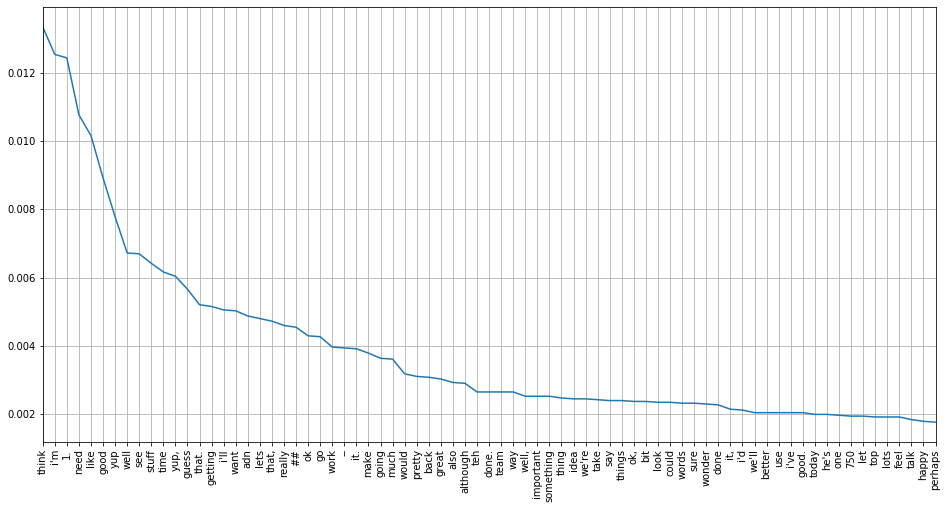

In [78]:
skip = 0
size = 75
pd["word"].value_counts(normalize=True).iloc[skip:skip+size] \
    .plot(rot=90, xticks=range(size), grid=True)

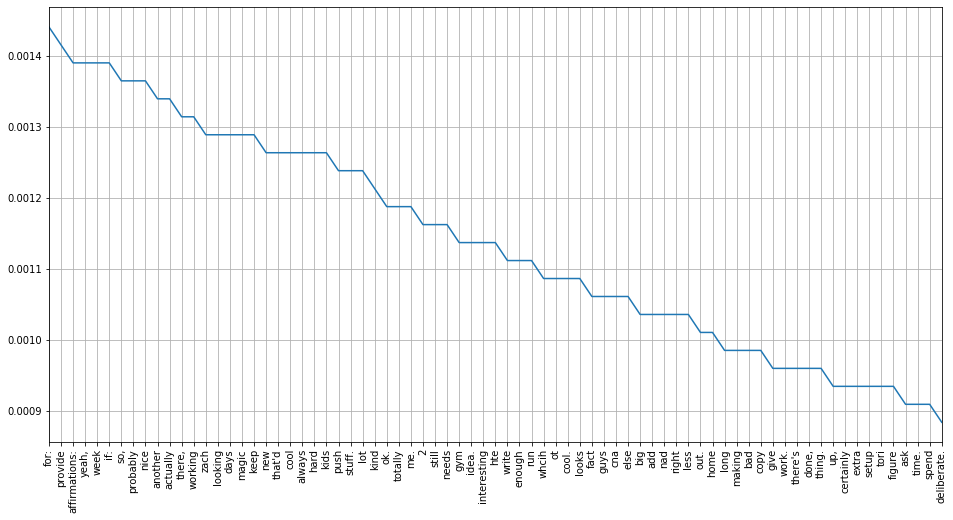

In [79]:
skip = 100
size = 75 
pd["word"].value_counts(normalize=True).iloc[skip:skip+size] \
    .plot(rot=90, xticks=range(size), grid=True)

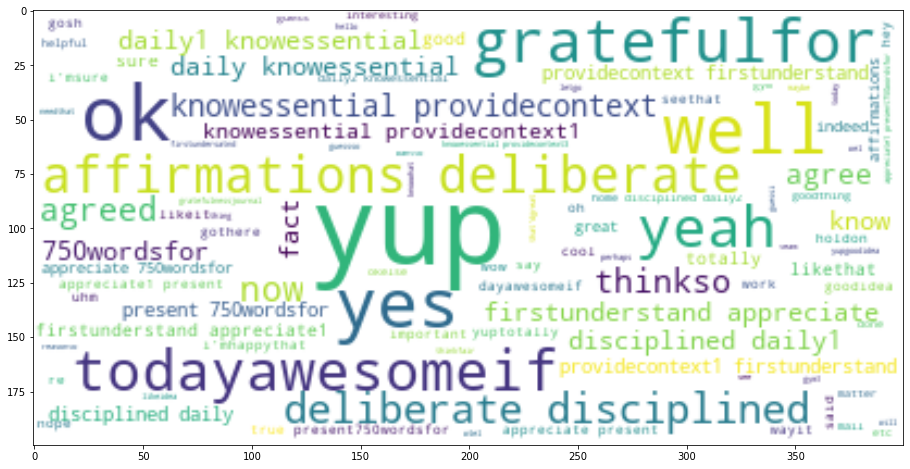

In [63]:
from wordcloud import WordCloud
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate("".join(words))
plt.imshow(wordcloud, interpolation='bilinear')